### Setup

In [1]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

### Parameters

In [2]:
beta = .442
#beta = .55
delta = .6415
sigma = 3
A = 1
alpha = .35

nvec = np.array([1.0, 1.0, .2])

f_params = nvec, A, alpha, delta

In [3]:
def get_w(bvec, w_args):
    b2, b3 = bvec
    A, alpha = w_args
    
    w = (1 - alpha) * A * (((b2+ b3) / (2.2)) ** alpha)
    
    return w

def get_r(bvec, r_args):
    b2, b3 = bvec
    A, alpha, delta = r_args
    
    r = alpha * A * ((2.2 / (b2 + b3)) ** (1 - alpha)) - delta
    
    return r

In [4]:
def feasible(f_params, bvec_guess):
    b2, b3 = bvec_guess
    nvec, A, alpha, delta = f_params
    
    K_cnstr = np.full(1, False)
    c_cnstr = np.full(3, False)
    b_cnstr = np.full(2, False)
    
    w_args = A, alpha
    r_args = A, alpha, delta
    
    w = get_w(bvec_guess, w_args)
    r = get_r(bvec_guess, r_args)
    
    c_cnstr[0] = w - b2 < 0 
    c_cnstr[1] = w + (1 + r) * b2 - b3 < 0
    c_cnstr[2] = .2*w + (1 + r) * b3 < 0
    
    K_cnstr[0] = b2 + b3 < 0
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
        
    return b_cnstr, c_cnstr, K_cnstr

In [5]:
bvec_guess1 = np.array([1.0, 1.2])
bvec_guess2 = np.array([0.06, -.001])
bvec_guess3 = np.array([0.1, 0.1])

feasible(f_params, bvec_guess1)
#feasible(f_params, bvec_guess2)
#feasible(f_params, bvec_guess3)

(array([ True, False]), array([ True, False, False]), array([False]))

In [6]:
def Eul_errs(bvec, *err_args):
    
    beta, sigma, A, alpha, delta = err_args
    b2, b3 = bvec
    
    w_args = A, alpha
    r_args = A, alpha, delta
    
    w = get_w(bvec, w_args) 
    r = get_r(bvec, r_args) 
    
    c1 = w - b2
    c2 = w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + 0.2 * w
    
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    
    err1 = MU1 - beta * (1 + r) * MU2
    err2 = MU2 - beta * (1 + r) * MU3
    
    return err1, err2

In [7]:
def get_SS(params, bvec_guess, SS_graphs):
    start_time = time.clock()
    
    b2, b3 = bvec_guess
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    err_args = beta, sigma, A, alpha, delta
    w_args = A, alpha
    r_args = A, alpha, delta
    
    results_ss = opt.root(Eul_errs, bvec_guess, tol=SS_tol, args=(err_args))
    
    b_ss = results_ss.x
    w_ss = get_w(b_ss, w_args)
    r_ss = get_r(b_ss, r_args)
    c_ss = np.array([w_ss - b_ss[0], 
                     w_ss + (1 + r_ss)*b_ss[0] - b_ss[1],
                     (1 + r_ss)*b_ss[1] + .2 * w_ss])
    K_ss = np.sum(b_ss)
    Y_ss = A * (K_ss ** alpha) * (L ** (1 - alpha))
    C_ss = Y_ss - K_ss + (1 - delta) * K_ss
    
    # are these errors returned by the root finder?
    EulErr_ss = np.array([beta * (1 + r_ss) * (c_ss[1] ** -sigma) - (c_ss[0] ** -sigma),
                          beta * (1 + r_ss) * (c_ss[2] ** -sigma) - (c_ss[1] ** -sigma)])
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock()
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss, 
        'ss_time': ss_time}
     
    if SS_graphs == True:
        fig, ax = plt.subplots(figsize=(6,6))
        s = np.array([1, 2, 3])
        plt.plot(s, c_ss, label=r'$\bar{c}_s$')
        plt.plot(s[1:], b_ss, label=r'$\bar{b}_s$')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.xlabel("Age (s)")
        plt.ylabel("Level")
        plt.xticks(s)
        plt.show()
        
    return ss_output

In [8]:
L = 2.2
SS_tol = .001
params = beta, sigma, nvec, L, A, alpha, delta, SS_tol

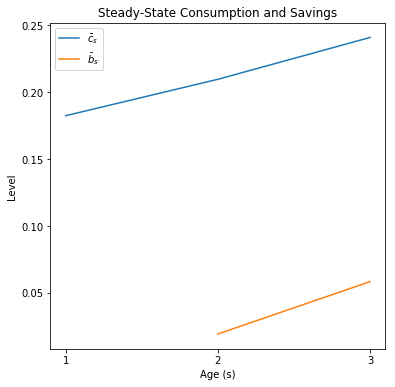

{'b_ss': array([0.01931262, 0.05841243]),
 'c_ss': array([0.18241333, 0.20961424, 0.24087656]),
 'w_ss': 0.20172594930955895,
 'r_ss': 2.433025771148647,
 'K_ss': 0.07772504796372812,
 'Y_ss': 0.6827647515092765,
 'C_ss': 0.632904133240545,
 'EulErr_ss': array([ 0.00253831, -0.0054862 ]),
 'RCerr_ss': -2.0816681711721685e-17,
 'ss_time': 1.406102}

In [9]:
results_ss = get_SS(params, np.array([.1, .1]), True)
results_ss